![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [73]:
# Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the data
weather = pd.read_csv("london_weather.csv")

weather.head()


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [74]:
# Set up MLflow and clean previous experiments
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Get all experiments
experiments = client.search_experiments()

for exp in experiments:
    # Skip the default experiment (experiment_id = "0")
    if exp.experiment_id != "0":
        print(f"Deleting experiment: {exp.name} (ID: {exp.experiment_id})")
        client.delete_experiment(exp.experiment_id)

print("All experiments deleted (except Default)!")

Deleting experiment: RF Model (ID: 769254455847661495)
Deleting experiment: DT Model (ID: 992146196960864114)
Deleting experiment: SGD Model (ID: 416290124111007725)
All experiments deleted (except Default)!


In [75]:
# Validate the data
print(f"number of missing values:\n{weather.isna().sum()}")
print(f"\ntypes of columns:\n{weather.dtypes}")
print(f"\nshape of the data:\n{weather.shape}")

# Delete rows with target variable being NaN
weather_cleaned = weather.copy().dropna(subset=['mean_temp'])

print(f"number of missing values after dropna:\n{weather_cleaned.isna().sum()}")
print(f"\nshape of the data after dropna:\n{weather_cleaned.shape}")

number of missing values:
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

types of columns:
date                  int64
cloud_cover         float64
sunshine            float64
global_radiation    float64
max_temp            float64
mean_temp           float64
min_temp            float64
precipitation       float64
pressure            float64
snow_depth          float64
dtype: object

shape of the data:
(15341, 10)
number of missing values after dropna:
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp              0
min_temp               0
precipitation          2
pressure               4
snow_depth          1424
dtype: int64

shape of the data after dropna:
(15305, 10)


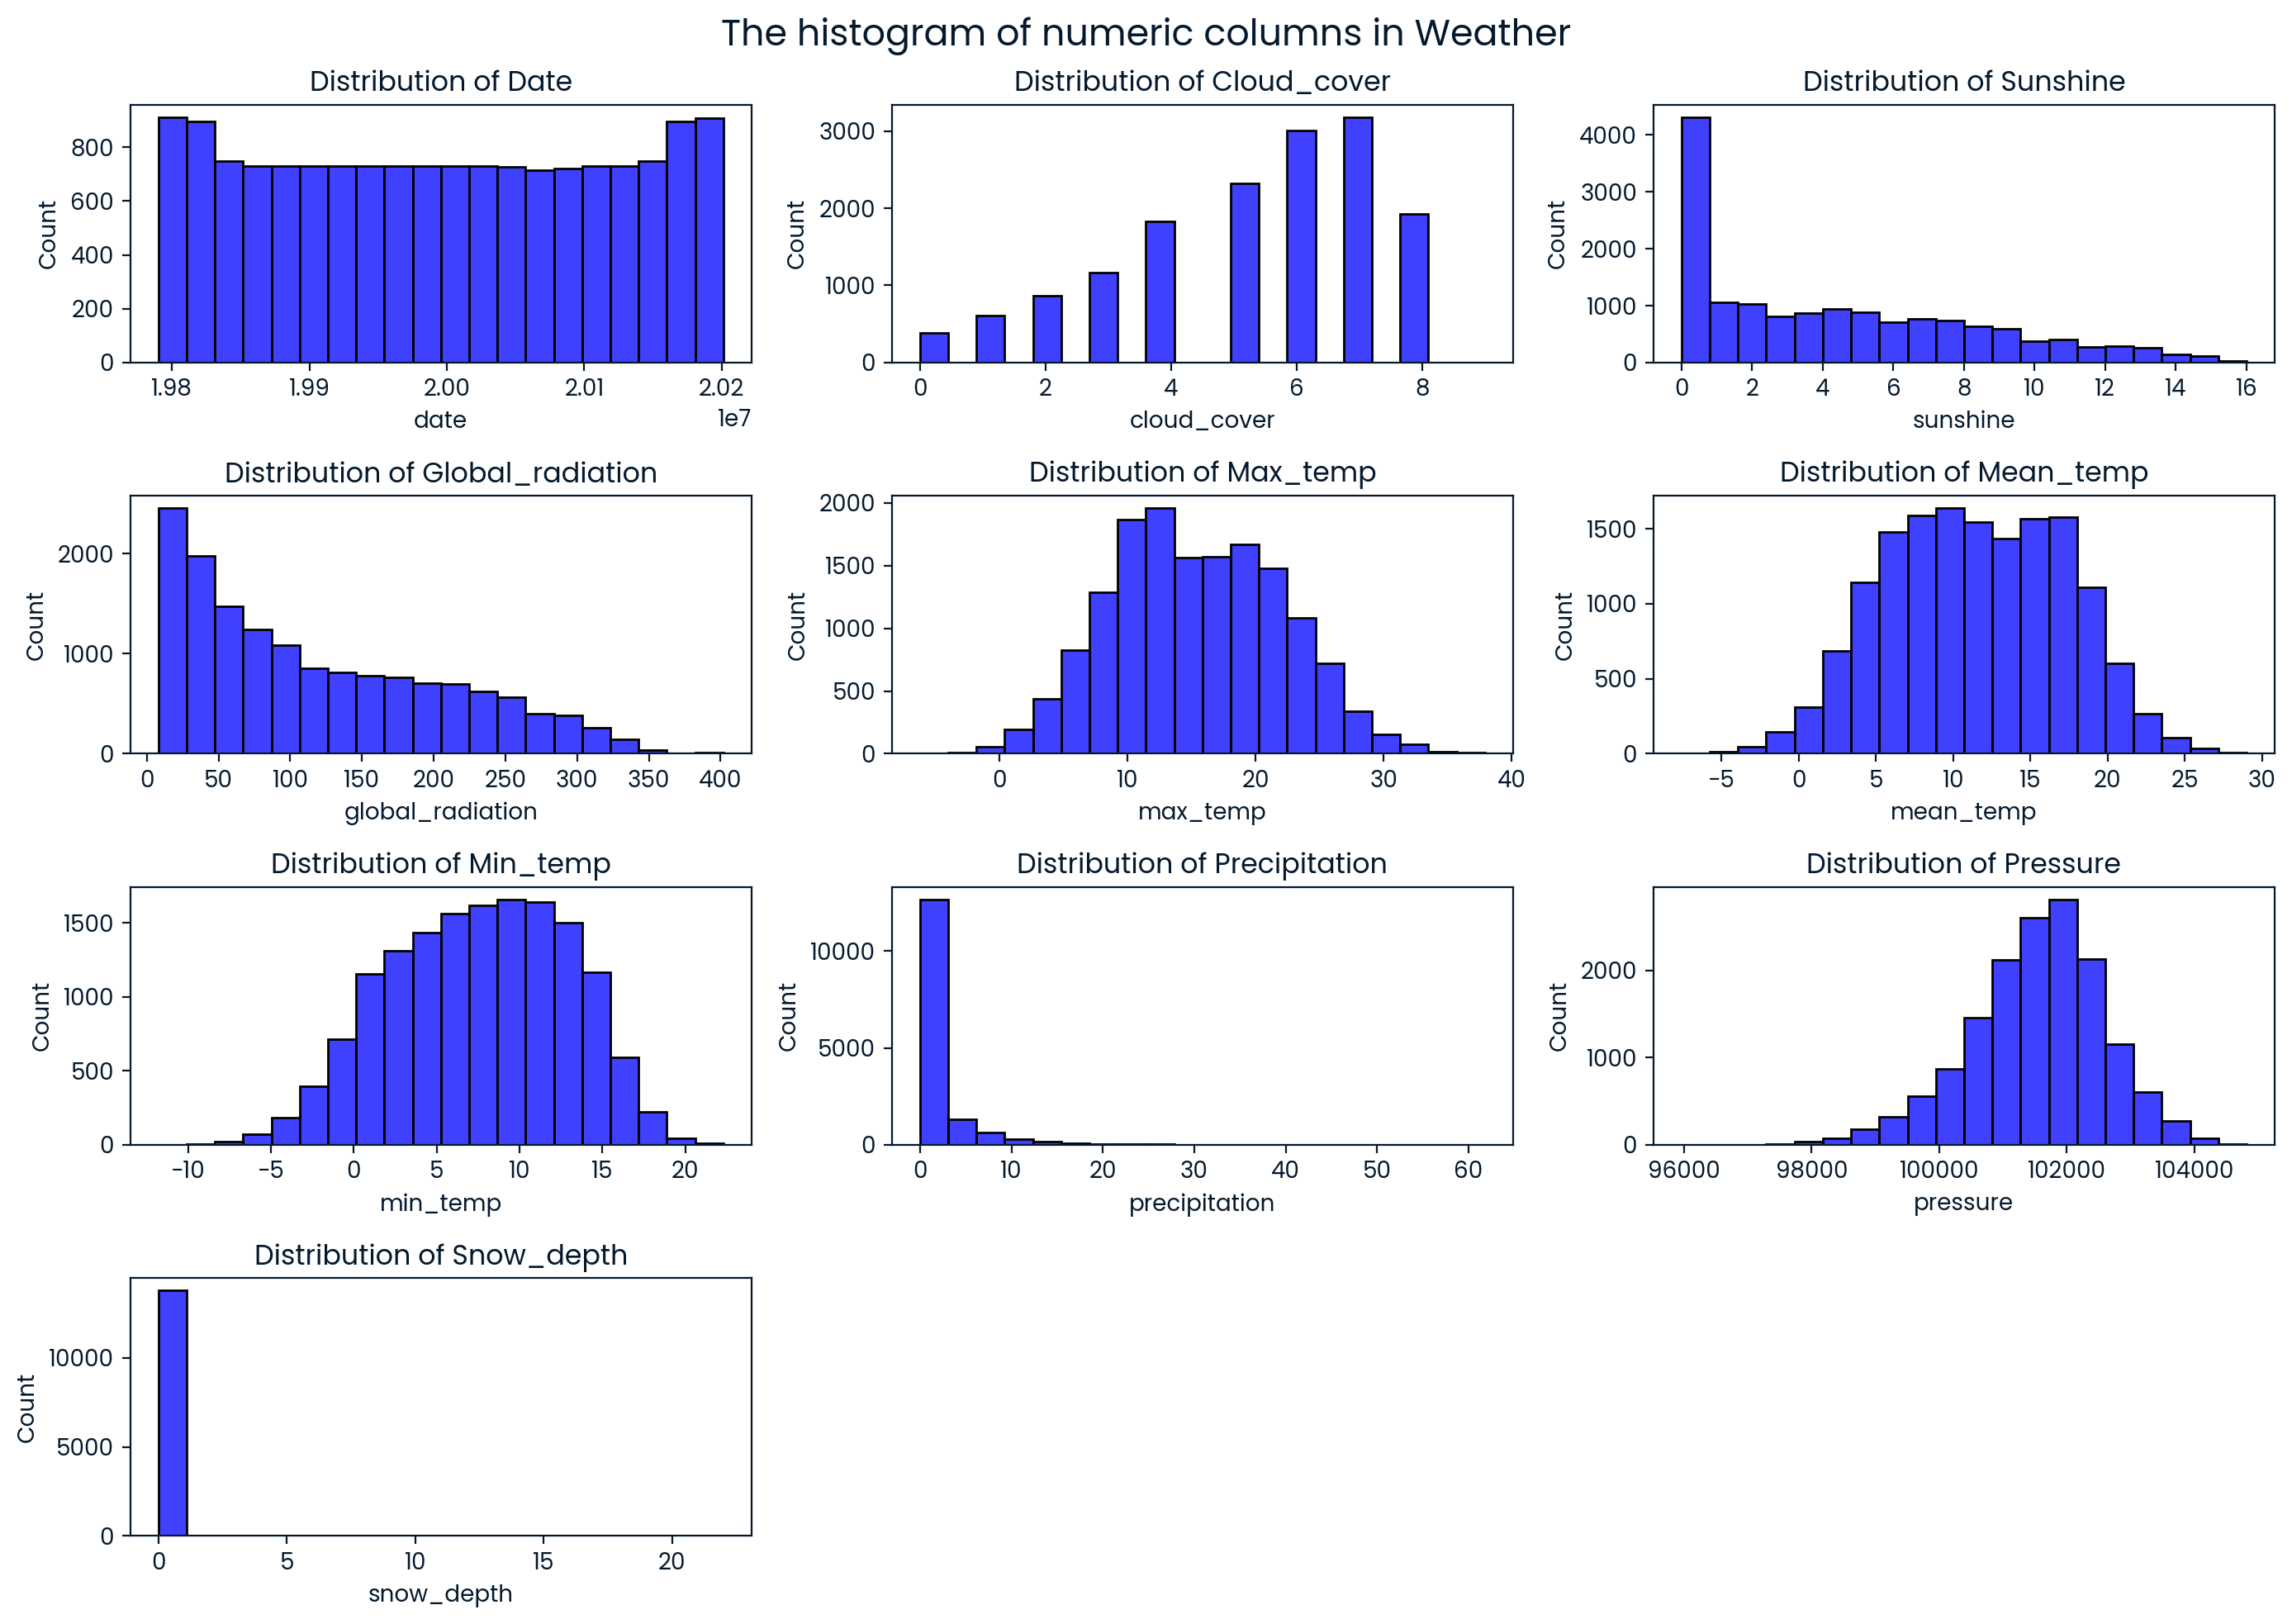

In [76]:
# Visualize the data
numeric_cols = weather_cleaned.select_dtypes(include=np.number)

num_cols =3
num_rows = len(numeric_cols.columns)//num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
fig.suptitle('The histogram of numeric columns in Weather', fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Create each plot
for idx, col in enumerate(numeric_cols.columns):
    sns.histplot(numeric_cols[col], ax=axes[idx], kde=False, bins=20, color='b')
    axes[idx].set_title(f'Distribution of {col.capitalize()}')

# Hide unused subplots if any
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
    

In [77]:
# Libs
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

# Define features and target variable
X = weather_cleaned.copy().drop('mean_temp', axis=1)
y = weather_cleaned[['mean_temp']]

# Define a random state to be used for all models
random_state_=123

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X,y, 
    shuffle=True, 
    random_state=random_state_
)

# Set up KFold to be used in all of the models
kf = KFold(n_splits=10, random_state=random_state_, shuffle=True)

# Define which score to be used for training and validation
which_score = 'neg_mean_squared_error'

# Set up preprocessing pipeline
num_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_and_log_gridsearch(
    experiment_name, 
    pipeline, 
    param_grid, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test):
    """Run and log the gridsearch for the input pipeline."""
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=f"{experiment_name}_gridsearch"):
        # GridSearchCV
        grid = RandomizedSearchCV(
            pipeline, 
            param_grid, 
            cv=kf, 
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1,
            n_iter=50,
            random_state=random_state_
        )
        grid.fit(X_train, y_train)
        
        # Log best params
        mlflow.log_params(grid.best_params_)
        
        # Predictions with best model
        y_pred = grid.best_estimator_.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_pred)
        train_test_gap = -grid.best_score_ - test_mse
        if train_test_gap < -0.1:
            is_overfitting = True
        else:
            is_overfitting = False
        
        # Log metrics
        mlflow.log_metric("best_cv_score", -grid.best_score_)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_r2", test_r2)
        mlflow.log_metric('is_overfitting', is_overfitting)
        
        # Log model
        mlflow.sklearn.log_model(grid.best_estimator_, "model")
        
        print(f"{experiment_name} - Test RMSE: {test_rmse:.4f}")
        
        return grid.best_estimator_

In [79]:
from sklearn.linear_model import SGDRegressor

# Initiate the model and create the pipeline
lr_pipe = Pipeline(steps=[
    ('prep', num_prep),
    ('SGD', SGDRegressor())
])

# Creat dictioanry of parameters for the GridSearch
lr_params = {
    'SGD__alpha': [0.0001, 0.001, 0.01],
    'SGD__penalty': ['l2', 'l1', 'elasticnet'],
    'SGD__learning_rate': ['constant', 'optimal'],
    'SGD__random_state': [random_state_]
}

# Train and log using mlflow
train_and_log_gridsearch('SGD Model', lr_pipe, lr_params)

2026/01/09 19:49:35 INFO mlflow.tracking.fluent: Experiment with name 'SGD Model' does not exist. Creating a new experiment.


SGD Model - Test RMSE: 0.8915


Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('power', PowerTransformer(standardize=False)),
                                 ('scaler', StandardScaler())])),
                ('SGD',
                 SGDRegressor(alpha=0.01, learning_rate='optimal',
                              random_state=123))])

In [80]:
from sklearn.tree import DecisionTreeRegressor

# Initiate the model and create the pipeline
dt_pipe = Pipeline(steps=[
    ('prep', num_prep),
    ('DT', DecisionTreeRegressor())
])

# Creat dictioanry of parameters for the GridSearch
dt_params = {
    'DT__max_depth': [3, 5, 7, 10, None],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [1, 2, 4],
    'DT__max_features': ['auto', 'sqrt', 'log2', None],
    'DT__random_state': [random_state_]
}

# Train and log using mlflow
train_and_log_gridsearch('DT Model', dt_pipe, dt_params)

2026/01/09 19:49:50 INFO mlflow.tracking.fluent: Experiment with name 'DT Model' does not exist. Creating a new experiment.


DT Model - Test RMSE: 0.9909


Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('power', PowerTransformer(standardize=False)),
                                 ('scaler', StandardScaler())])),
                ('DT',
                 DecisionTreeRegressor(max_depth=10, max_features='auto',
                                       min_samples_leaf=4, random_state=123))])

In [81]:
from sklearn.ensemble import RandomForestRegressor

# Initiate the model and create the pipeline
rf_pipe = Pipeline(steps=[
    ('prep', num_prep),
    ('RF', RandomForestRegressor())
])

# Creat dictioanry of parameters for the GridSearch
rf_params = {
    'RF__n_estimators': [100, 200],
    'RF__max_depth': [10, 15],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
    'RF__max_features': ['sqrt', 'log2'],
    'RF__random_state': [random_state_]
}

# Train and log using mlflow
train_and_log_gridsearch('RF Model', rf_pipe, rf_params)

2026/01/09 19:50:23 INFO mlflow.tracking.fluent: Experiment with name 'RF Model' does not exist. Creating a new experiment.


RF Model - Test RMSE: 0.8420


Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('power', PowerTransformer(standardize=False)),
                                 ('scaler', StandardScaler())])),
                ('RF',
                 RandomForestRegressor(max_depth=15, max_features='sqrt',
                                       n_estimators=200, random_state=123))])

In [82]:
exp_names = ["SGD Model", "DT Model", "RF Model"]

exps = [mlflow.get_experiment_by_name(n) for n in exp_names]
missing = [n for n, e in zip(exp_names, exps) if e is None]
if missing:
    raise ValueError(f"Experiments not found: {missing}")

exp_ids = [e.experiment_id for e in exps]

experiment_results = mlflow.search_runs(
    experiment_ids=exp_ids,
    filter_string="metrics.test_rmse < 3",
    order_by=["metrics.test_rmse ASC"]
)

experiment_results[["experiment_id", "tags.mlflow.runName", "metrics.test_rmse", "metrics.test_r2", "start_time", "end_time"]]

,experiment_id,tags.mlflow.runName,metrics.test_rmse,metrics.test_r2,start_time,end_time
0,711735833667958318,RF Model_gridsearch,0.842007,0.978641,2026-01-09 19:50:24.068000+00:00,2026-01-09 19:58:19.927000+00:00
1,226644708445549930,SGD Model_gridsearch,0.891459,0.976059,2026-01-09 19:49:35.876000+00:00,2026-01-09 19:49:50.630000+00:00
2,851677809912418316,DT Model_gridsearch,0.990939,0.970417,2026-01-09 19:49:50.995000+00:00,2026-01-09 19:50:23.647000+00:00
